LangGraph 具有内置的持久化层，通过检查点器实现。当你使用检查点器编译图时，检查点器会在每个超级步骤中保存图状态的 checkpoint 。这些检查点会保存到 thread ，在图执行后可以访问。由于 threads 允许在执行后访问图的状态，因此可以实现多种强大的功能，包括人工介入、记忆、时间旅行和容错性。

## 1、Thread

线程是检查点器为每个保存的检查点分配的唯一 ID 或线程标识符。它包含一系列运行累积的状态。当执行运行时，助手底层图的状态将被持久化到线程。

{"configurable": {"thread_id": "1"}}

## 2、CheckPoints

一个线程在特定时间点的状态被称为检查点。检查点是每次超级步骤时保存的图状态的快照，由 StateSnapshot 对象表示。

Others：
- https://juejin.cn/post/7535740692191182874

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config: RunnableConfig = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": "", "bar":[]}, config)

{'foo': 'b', 'bar': ['a', 'b']}

上述代码中有四个检查点：

### 2.1 获取状态

In [10]:
# get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

# get a state snapshot for a specific checkpoint_id
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1ef663ba-28fe-6528-8002-5a559208592c"}}
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1ef663ba-28fe-6528-8002-5a559208592c'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

### 2.2 获取状态历史

In [11]:
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d666d-9eeb-6ba3-8002-0d46272196fd'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-11T07:56:07.979510+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d666d-9ee9-6481-8001-2a2d264a2e7d'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d666d-9ee9-6481-8001-2a2d264a2e7d'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-12-11T07:56:07.978508+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d666d-9ee9-6480-8000-f2b982bda5a7'}}, tasks=(PregelTask(id='68078614-f1a3-b789-0290-842b3a20b56e', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts

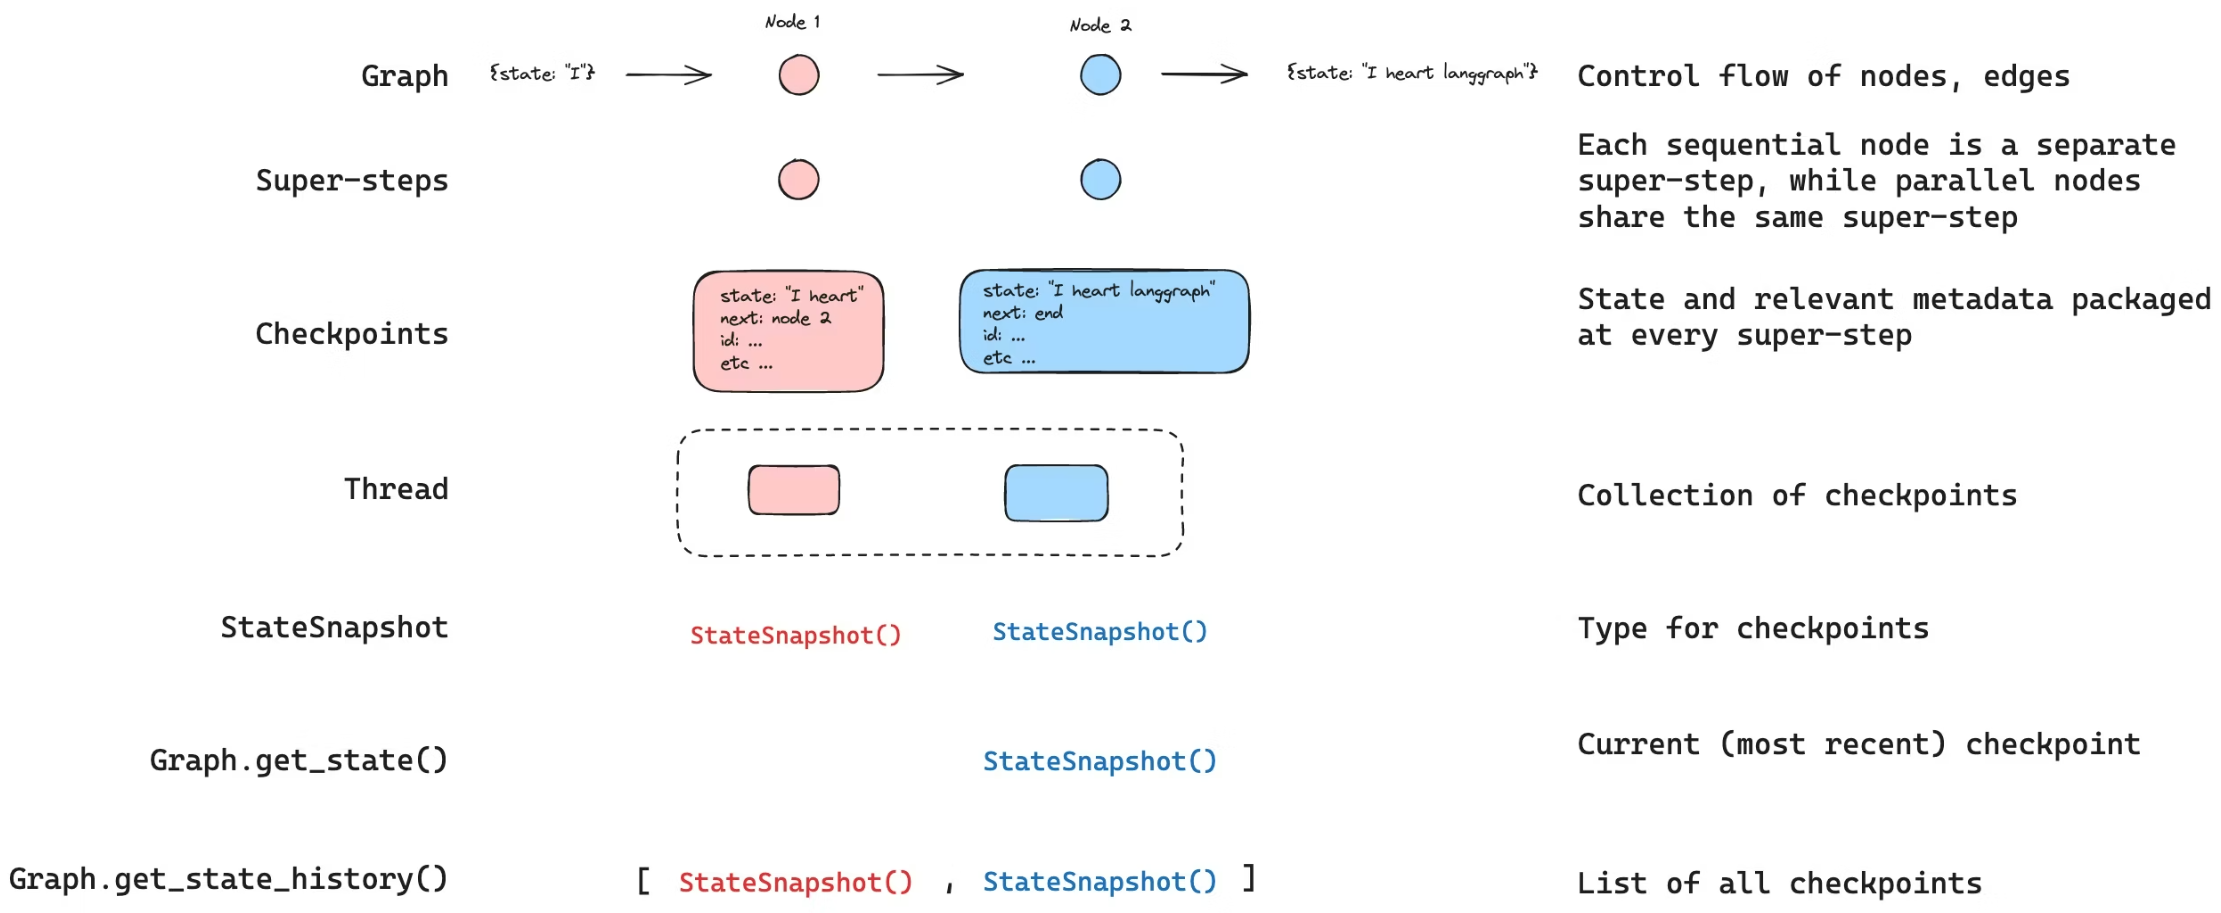

### 2.3 重播

In [12]:
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1f0d666d-9ee6-6d83-bfff-186d7b4500e5"}}  # 修改成自己的id
graph.invoke(None, config=config)

{'foo': 'b', 'bar': ['a', 'b']}

### 2.4 更新状态

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: int
    bar: Annotated[list[str], add]

In [14]:
graph.update_state(config, values={"foo": 2, "bar": ["b"]})

KeyError: 'checkpoint_ns'

## 3、内存存储

仅使用检查点器，我们无法跨线程共享信息。这促使我们需要 Store 接口。作为一个示例，我们可以定义一个 InMemoryStore 来跨线程存储用户信息。我们只需像之前一样，使用检查点器编译我们的图，并使用我们的新 in_memory_store 变量。

备注：
-  当使用 LangGraph API 时，LangGraph API 自动处理存储，你无需手动实现或配置存储。该 API 在后台为你处理所有存储基础设施。

### 3.1 基础用法

In [3]:
from langgraph.store.memory import InMemoryStore
import uuid
in_memory_store = InMemoryStore()

user_id = "1"
namespace_for_memory = (user_id, "memories")

memory_id = str(uuid.uuid4())
memory = {"food_preference" : "I like pizza"}
in_memory_store.put(namespace_for_memory, memory_id, memory)

memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': 'c1eed63f-21d3-49d0-a9ac-67fc3b537ab8',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-12-12T01:52:05.215338+00:00',
 'updated_at': '2025-12-12T01:52:05.215338+00:00',
 'score': None}

### 3.2 语义搜索

In [9]:
# from langchain.embeddings import init_embeddings
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os

# 加载环境变量
load_dotenv(override=False)  # override=False 避免.env覆盖系统环境变量

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    openai_api_key=os.getenv("OPENROUTER_API_KEY"),
    openai_api_base=os.getenv("BASE_URL")
)

store = InMemoryStore(
    index={
        # "embed": init_embeddings("openai:text-embedding-3-small"),  # Embedding provider
        "embed": embeddings,
        "dims": 1536,                              # Embedding dimensions
        "fields": ["food_preference", "$"]              # Fields to embed
    }
)

In [10]:
# Store with specific fields to embed
store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {
        "food_preference": "I love Italian cuisine",
        "context": "Discussing dinner plans"
    },
    index=["food_preference"]  # Only embed "food_preferences" field
)

# Store without embedding (still retrievable, but not searchable)
store.put(
    namespace_for_memory,
    str(uuid.uuid4()),
    {"system_info": "Last updated: 2024-01-01"},
    index=False
)

ValueError: No embedding data received

In [11]:
# Find memories about food preferences
# (This can be done after putting memories into the store)
memories = store.search(
    namespace_for_memory,
    query="What does the user like to eat?",
    limit=3  # Return top 3 matches
)

ValueError: No embedding data received

### 3.3 在 LangGraph 中使用

## 4、Checkpointer libraries